In [22]:
import numpy as np
import pandas as pd
import featuretools as ft
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')

In [10]:
len(log_df['track_id_clean'].unique())

50704

In [6]:
log_df['track_id_clean'].value_counts()[0:60]

t_bacf06d3-9185-4183-84ea-ff0db51475ce    1427
t_5718ab08-3a15-4d3f-9e63-42b2f6805e31     915
t_8c4d29b1-e0bf-464c-88f7-ac19240cbba0     785
t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5     730
t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a     719
t_9a31436c-a57a-4d7a-9bbc-50f0deca33de     612
t_0e3dec82-10b4-49f1-8c2e-cd19249f7d2c     600
t_2fd6279a-06cd-4d5d-9e54-1912f51bb3c3     593
t_7533e7ff-568e-448b-904e-fc0c3a9ec87e     576
t_29a3895e-2c91-49a6-9383-6a71c597390d     548
t_0ef6d2c8-faf9-4ebe-ac75-2bade8696a3d     536
t_68888d19-7be6-4cdc-bcfb-be38431f79d7     528
t_32270005-26a1-4763-8ba5-44fcc15f9914     496
t_a0fa9956-ffc3-41c9-a344-e247baa0e321     488
t_abe577df-bc3e-48ff-a13c-f2fd7a295ba6     484
t_8f9f2397-334b-48ee-9120-96d9ddf32f92     484
t_9229bbff-130d-4668-8e84-6b35c7b7cea0     457
t_312b3509-48c1-4928-a6e5-d3e7a51c216b     448
t_81b9a202-281e-42a4-b068-e0c0f44e1e4d     447
t_7e616ed3-115f-4a97-b90e-d128c392fae0     445
t_1dba18ad-1ddb-4e97-983b-4af57e18d84a     437
t_f5205a27-c6

In [16]:
play1 = (log_df['track_id_clean'].value_counts()==1).sum()/len(log_df['track_id_clean'].unique())*100
play5 = (log_df['track_id_clean'].value_counts()<=5).sum()/len(log_df['track_id_clean'].unique())*100
play10 = (log_df['track_id_clean'].value_counts()<=10).sum()/len(log_df['track_id_clean'].unique())*100

print('% of tracks only been played 1 time:',play1)
print('% of tracks only been played 5 times of less:',play5)
print('% of tracks only been played 10 times of less:',play10)

% of tracks only been played 1 time: 62.7623067213632
% of tracks only been played 5 times of less: 91.48193436415272
% of tracks only been played 10 times of less: 96.14034395708426


# Try clustering the tracks by their acoustic features

As 91.5% of the tracks has only been played 5 times of less, the similar tracks have to be grouped into clusters to do Collaborative Filtering.

In [17]:
tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])


In [19]:
from sklearn.preprocessing import StandardScaler

sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df_dummy[sel_col_names]

scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)


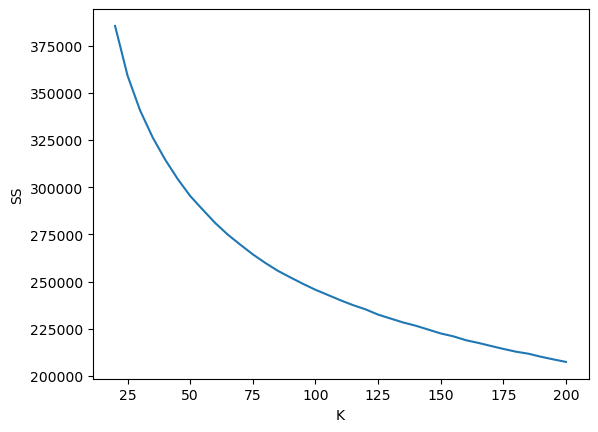

In [24]:
from sklearn.cluster import KMeans
inertia = []
nClusters = []

for k in range(20,205,5):
    model = KMeans(n_clusters = k)
    model.fit(x_cols_scaled)
    inertia.append(model.inertia_)
    nClusters.append(k)
    
plt.plot(nClusters,inertia)
plt.xlabel('K')
plt.ylabel('SS')
plt.show()

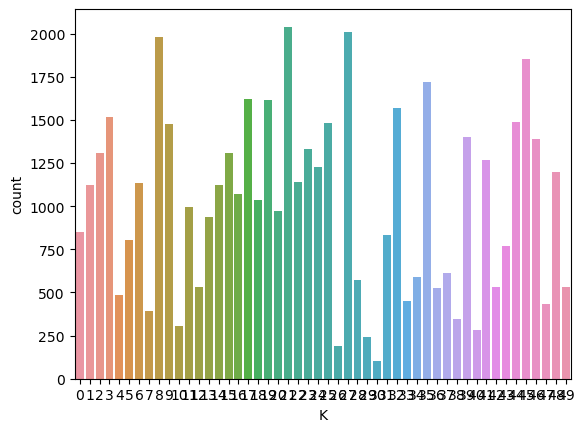

In [60]:
km_model = KMeans(n_clusters = 50)
km_model.fit(x_cols_scaled)
clus = pd.DataFrame(km_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.show()

In [61]:
tf_df_dummy['clus'] = clus

In [62]:
# perform a simple dataframe join
df = log_df.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df.head().T

,0,45,50,327,353
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
session_length,20,20,20,20,20
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123
skip_1,False,False,False,False,False
...,...,...,...,...,...
time_signature_4,1,1,1,1,1
time_signature_5,0,0,0,0,0
mode_major,1,0,1,1,1
mode_minor,0,1,0,0,0


## Recommendation Filtering

https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a
https://github.com/DAR-DatenanalyseRehberg/RecommenderBinaryCF/blob/main/RecommenderCollaborativeFilteringDDDD.ipynb

In [63]:
sessions = list(np.sort(df['session_id'].unique())) 
# tracks = list(df['track_id_clean'].unique()) 
tracks = list(df['clus'].unique()) 
no_skip_1 = list(df['skip_1']==False) 

In [64]:
DfSessionUnique = []
DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
DfSessionUnique.head()

,sessions
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130


In [65]:
from scipy import sparse
from pandas.api.types import CategoricalDtype

rows = df['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # We have got 36 unique customers, which make up 13837 data rows (index)

# Get the associated row indices
cols = df['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # We have got unique 3725 SalesItems, making up 13837 data rows (index)


In [66]:
# Get the associated column indices
#Compressed Sparse Row matrix
listeningSparse = []
listeningSparse = sparse.csr_matrix((no_skip_1*1, (rows, cols)), shape=(len(sessions), len(tracks))) #len of customers=35, len of products=3725
#csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

listeningSparse
#a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products

<10000x50 sparse matrix of type '<class 'numpy.bool_'>'
	with 73946 stored elements in Compressed Sparse Row format>

In [67]:
#We have 35 customers with 3725 items. For these user/item interactions, 13837 of these items had a purchase. 
#In terms of sparsity of the matrix, that makes:
MatrixSize = listeningSparse.shape[0]*listeningSparse.shape[1] # 130375 possible interactions in the matrix (35 unique customers * 3725 unique SalesItems=130375)
listeningAmount = len(listeningSparse.nonzero()[0]) # 13837 SalesItems interacted with; 
sparsity = 100*(1 - (listeningAmount/MatrixSize))
sparsity

89.4668

## Recommending

In [70]:
#for every dataset we will add a 1 as purchased. That means, that this customer has purchased this item, no matter how many. We use this binary data for our recommending. Another approach would be to use the SalesAmount and 
#normalize it, in case you want to treat the Amount of SalesItems purchased as a kind of taste factor, meaning that someone who bought SalesItem x 100 times, while another Customer bought that same SalesItem x only 5 times does 
#not like it as much. I believe, that very often in Sales a binary approach makes more sense, but of course that depends on the data.
def create_DataBinary(df):
  # DataPrep must be DataGrouped?!
    DataBinary = df.copy()
    DataBinary['ListenYes'] = 1 
    return DataBinary

DataBinary = create_DataBinary(df)
DataBinary.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,mode_major,mode_minor,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,0,1,0,1,0,43,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,0,1,0,0,1,21,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,27,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,39,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,44,1


In [72]:
data2=DataBinary[['session_id','clus','ListenYes']]
data2.head()

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,21,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,27,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,39,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,44,1


In [73]:
#for better convenience we add I for Item for every SalesItem. Otherwise we would only have customer and SalesItem Numbers, which can be a little bit puzzling.
data2['clus'] = 'c' + data2['clus'].astype(str)

In [74]:
#DfMatrix = pd.pivot_table(data,index=["Customer"], columns='SalesItem')
DfMatrix = pd.pivot_table(data2, values='ListenYes', index='session_id', columns='clus')
DfMatrix.head()

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0_0000a72b-09ac-412f-b452-9b9e79bded8f,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0_00016a3d-9076-4f67-918f-f29e3ce160dc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
#since we are only using 1 and 0, we do not need to think about normalization. But talk is cheap, let`s check to see that even if we would normalize, the result is the same, of course:
DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been purchased yet.
DfMatrixNorm3 = (DfMatrix-DfMatrix.min())/(DfMatrix.max()-DfMatrix.min())
DfMatrixNorm3.head()
#the proof is in the pudding. But we will come back to normalization later on again, when we will take real Sales Amount into consideration for recommending as well.

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
#we need to bring our pivot table into the desired format, via reset_index and rename_axis. 
DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 
DfResetted.head()
#Now each row represents one customer`s buying behaviour: 1 means the customer has purchased, NaN the customer has not yet purchased it

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
DfMatrix.shape

(10000, 50)

In [78]:
DfTracksListen = DfResetted.drop(columns=['session_id'])
DfTracksListen.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
#Calculate the Item based recommendation
import numpy as np
# We will normalize dataframe now, due to ..
#I believe we do not need to normalize, but let us compare..
#vectorized
DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 
DfTracksListenNorm.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0.020572,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.016197,0.0,0.000000,...,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.0000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.028548,0.000000,0.0,0.000000,...,0.00000,0.022698,0.0,0.000000,0.04897,0.0,0.0349,0.0,0.000000,0.000000
2,0.020572,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.016197,0.0,0.000000,...,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.0000,0.0,0.014306,0.000000
3,0.000000,0.030317,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.024383,...,0.00000,0.022698,0.0,0.000000,0.00000,0.0,0.0000,0.0,0.000000,0.030192
4,0.000000,0.000000,0.0,0.0,0.0,0.034381,0.000000,0.000000,0.0,0.024383,...,0.01765,0.022698,0.0,0.024485,0.00000,0.0,0.0000,0.0,0.000000,0.000000


In [80]:
# Calculating with Vectors to compute Cosine Similarities
TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 
TrackTrackSim.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,0.084195,0.016974,0.145481,0.091318,0.086286,0.131551,0.448807,0.126291,0.089786,...,0.279943,0.145216,0.028041,0.216590,0.056414,0.019280,0.054564,0.030997,0.459698,0.057142
c1,0.084195,1.000000,0.021889,0.256038,0.126931,0.228268,0.420629,0.066289,0.143374,0.311950,...,0.192100,0.282823,0.223845,0.132874,0.106893,0.041872,0.341756,0.055299,0.122309,0.245311
c10,0.016974,0.021889,1.000000,0.021099,0.000000,0.031915,0.023556,0.031740,0.012119,0.025149,...,0.034589,0.021070,0.023432,0.025254,0.161629,0.005088,0.025198,0.032719,0.051645,0.012456
c11,0.145481,0.256038,0.021099,1.000000,0.089920,0.267250,0.312012,0.127794,0.139058,0.250814,...,0.216114,0.186387,0.114522,0.283347,0.097311,0.025946,0.219275,0.104288,0.145905,0.184402
c12,0.091318,0.126931,0.000000,0.089920,1.000000,0.083245,0.093604,0.071080,0.176323,0.075028,...,0.113072,0.136250,0.083085,0.080282,0.046934,0.012441,0.082743,0.084009,0.098144,0.045690


In [81]:
#Another approach to the above would be using corr fct
#Where is the difference?
TrackTrackCorr = DfTracksListenNorm.corr()
TrackTrackCorr.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,-0.092300,-0.034670,-0.025409,-0.005895,-0.065903,-0.047311,0.216276,-0.047706,-0.137483,...,0.006291,-0.087884,-0.066895,0.022638,-0.050091,-0.092631,-0.101188,-0.034949,0.191872,-0.125958
c1,-0.092300,1.000000,-0.010740,0.161396,0.066509,0.146507,0.345035,-0.184974,0.035014,0.205197,...,0.006708,0.162249,0.178384,-0.002135,0.042782,-0.027042,0.273364,0.014636,-0.160354,0.152750
c10,-0.034670,-0.010740,1.000000,-0.012916,-0.019702,0.003901,-0.011162,-0.035916,-0.022320,-0.016099,...,-0.024803,-0.024225,0.006493,-0.015787,0.145569,-0.014947,-0.002708,0.020756,-0.022656,-0.020930
c11,-0.025409,0.161396,-0.012916,1.000000,0.023976,0.186560,0.218322,-0.112947,0.025534,0.128908,...,0.028717,0.042234,0.058676,0.167414,0.029823,-0.047199,0.134659,0.065590,-0.138837,0.080152
c12,-0.005895,0.066509,-0.019702,0.023976,1.000000,0.027282,0.026319,-0.066558,0.118091,-0.007021,...,0.000934,0.055587,0.049936,-0.000763,0.006724,-0.028911,0.027624,0.060691,-0.057676,-0.021593


In [95]:
#ItemItemSim.to_excel("ExportItem-Item.xlsx")
# Create a placeholder items for closes neighbours to an item
TrackNeighbours = pd.DataFrame(index=TrackTrackSim.columns,columns=range(1,51))
TrackNeighbours.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# Create a placeholder items for closes neighbours to an item
#ItemNeighbours = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,10)) 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(TrackTrackSim.columns)):
    TrackNeighbours.iloc[i,:50] = TrackTrackSim.iloc[0:,i].sort_values(ascending=False)[:50].index
    #we only have 9 items, so we can max recommend 9 items (itself included)

TrackNeighbours

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,c0,c21,c27,c39,c8,c15,c23,c32,c3,c42,...,c34,c29,c28,c2,c40,c7,c47,c5,c10,c30
c1,c1,c14,c18,c6,c35,c17,c46,c22,c11,c9,...,c41,c42,c7,c29,c5,c19,c2,c26,c10,c30
c10,c10,c49,c26,c3,c27,c21,c8,c42,c34,c25,...,c31,c29,c40,c24,c5,c2,c37,c19,c38,c12
c11,c11,c22,c14,c48,c13,c1,c17,c24,c39,c6,...,c12,c25,c41,c29,c42,c5,c10,c30,c19,c2
c12,c12,c33,c37,c16,c31,c46,c4,c38,c1,c44,...,c29,c49,c9,c34,c26,c5,c30,c2,c19,c10
c13,c13,c6,c20,c34,c22,c49,c36,c9,c11,c14,...,c7,c32,c31,c5,c42,c41,c2,c10,c19,c30
c14,c14,c1,c18,c22,c11,c6,c17,c35,c13,c47,...,c40,c7,c42,c41,c29,c5,c2,c10,c19,c30
c15,c15,c21,c8,c44,c27,c32,c25,c39,c0,c3,...,c28,c47,c10,c34,c5,c38,c7,c40,c29,c30
c16,c16,c45,c31,c37,c46,c17,c3,c39,c27,c48,...,c40,c38,c49,c19,c29,c5,c26,c2,c30,c10
c17,c17,c24,c9,c46,c22,c45,c1,c48,c35,c14,...,c38,c40,c33,c26,c19,c29,c5,c2,c10,c30
